In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# для анализа выбран ряд Monthly sales of company X

In [3]:
series = pd.read_csv("C:/Users/yullH/bp/monthly-sales-of-company-x-jan-6.csv")['Count']

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\yullH\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


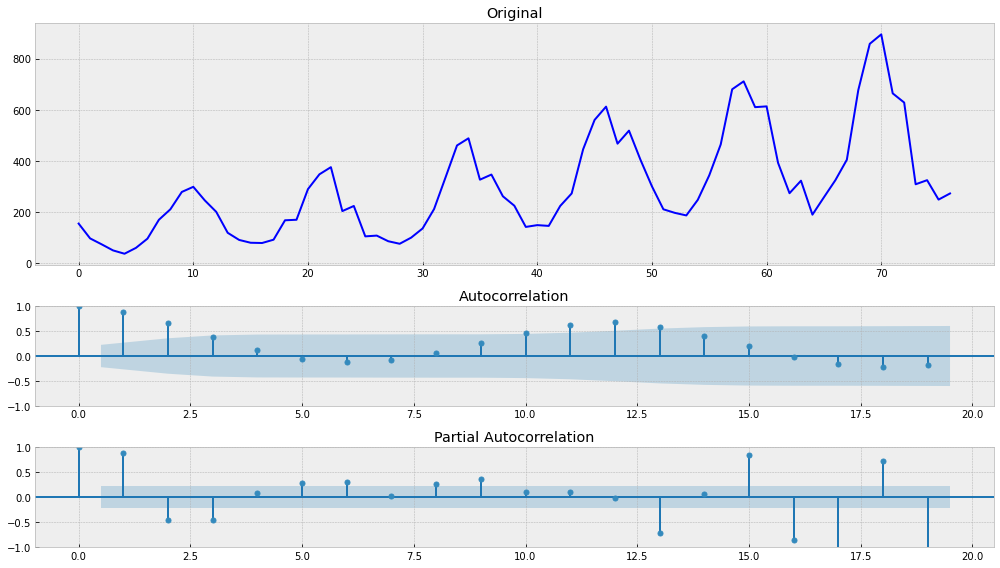

In [5]:
tsplot(series)

# Ряд не стационарен имеет тренд и сезонность


Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\yullH\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


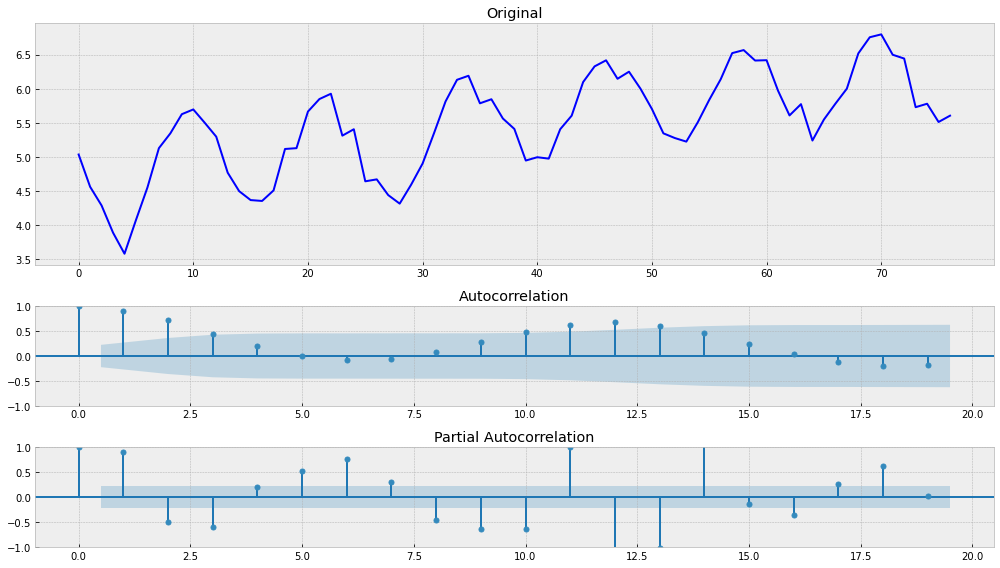

In [6]:
#нормализуем дисперсию
sales = boxcox(series, 0)

#построим график
tsplot(sales)

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\yullH\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


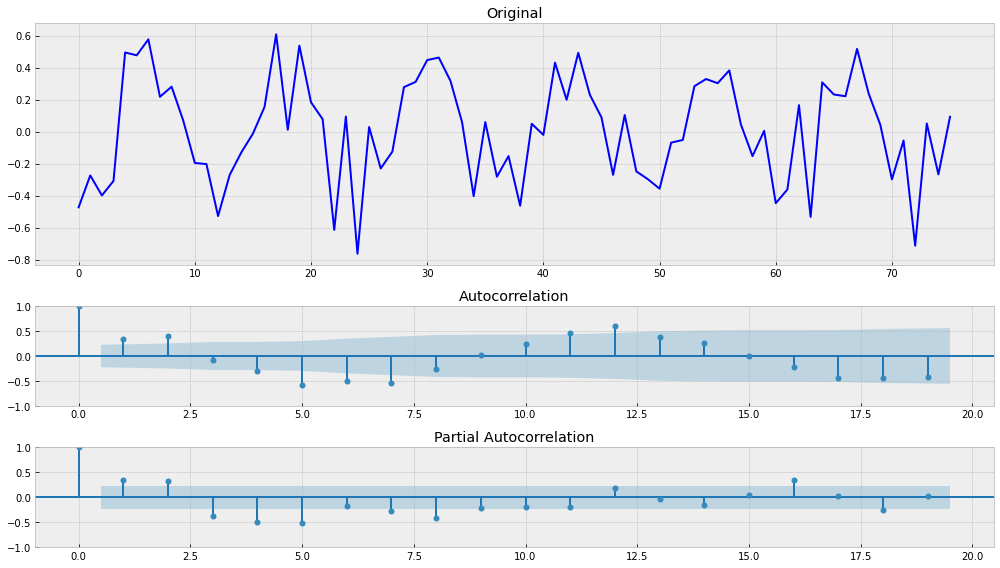

In [7]:
#дифференцируем
sales = np.diff(sales, 1)
tsplot(sales)

# Так как исходный ряд имеет и сезонность, и тренд применим модель Хольта - Винтерса


In [8]:
def initial_trend(series, season_len):
    return sum([float(series[1 + season_len] - series[1]) / season_len]) / season_len

In [9]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [10]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [11]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

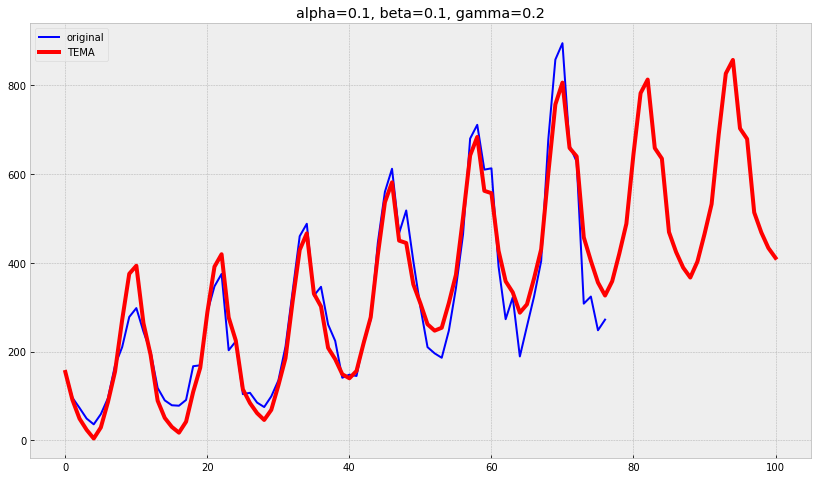

In [12]:
plot_tema(0.1, 0.1, 0.2)

Минимизируем функцию ошибки. посчитаем RMSE:

In [13]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [14]:
train, test, val = series[:60], series[60:70], series[70:]

In [15]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [16]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [17]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2931.8919326375194
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.04680725e-02, -1.03227649e-02, -1.01738564e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 164
      nit: 22
     njev: 41
   status: 0
  success: True
        x: array([0.26932098, 0.12270521, 1.        ])


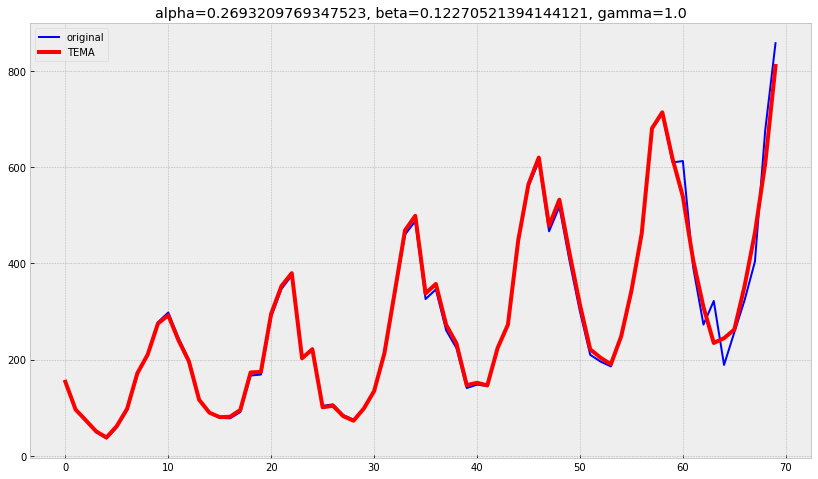

In [18]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

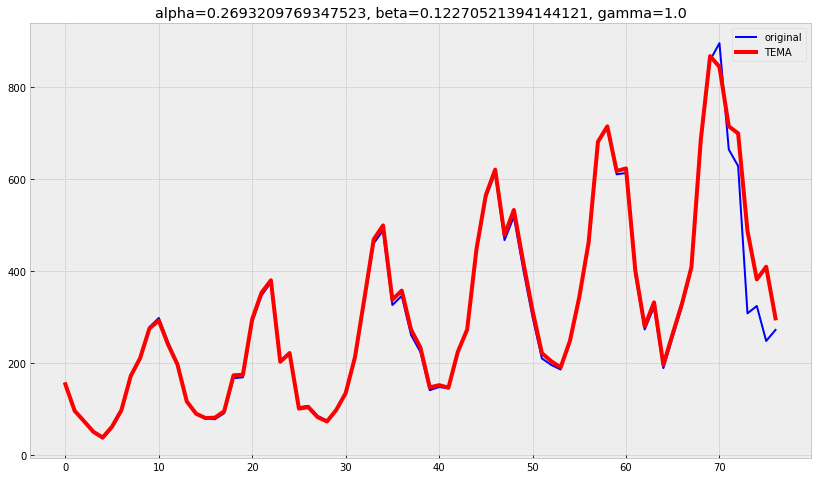

In [19]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

# Для стационарного ряда применим экспоненциальное сглаживание. которое учитывает временной контекст, но не учитывает вличние тренда и сезонности от которых избавились ранее


In [20]:
def exponential_moving_average(sales, alpha):
    result = [sales[0]]
    for n in range(1, len(sales)):
        result.append(alpha * sales[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

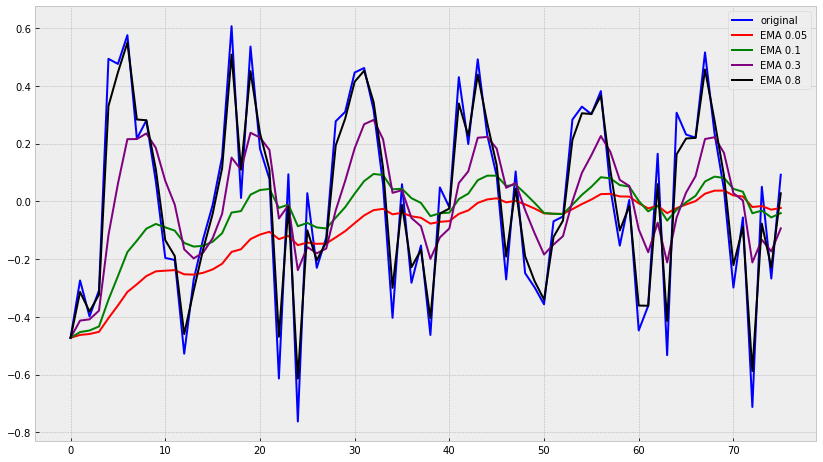

In [21]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(sales, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [22]:
trains, tests, vals = sales[:50], sales[50:60], sales[60:]

In [23]:
def mses(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(trains, 12, alpha, beta, gamma, len(tests))
    predictions = result[-len(tests):]
    error = mean_squared_error(predictions, tests)
    return error

In [24]:
opts = minimize(mses, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [25]:
alpha_opts, beta_opts, gamma_opts = opts.x
print(opts)

      fun: 0.026678571812817537
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.8319184e-02,  5.1278426e-07, -0.0000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([1.        , 0.01094842, 1.        ])


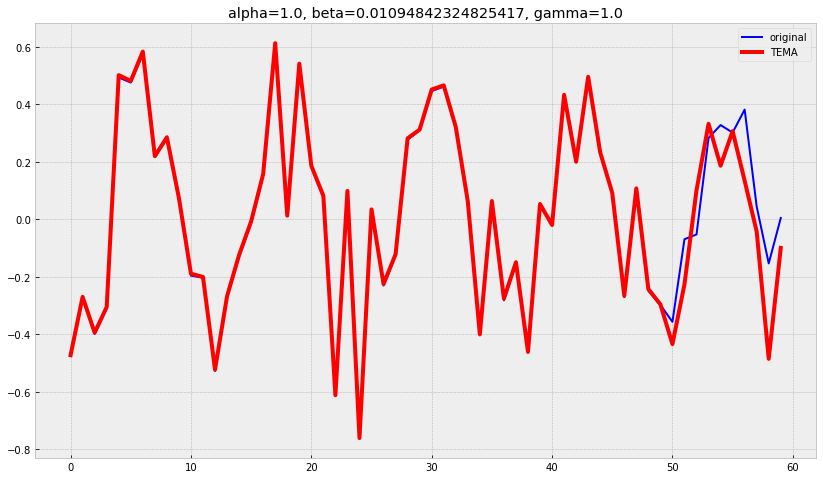

In [26]:
plot_tema(alpha_opts, beta_opts, gamma_opts, ser=trains, ser_to_plot=sales[:60], n_preds=len(tests))

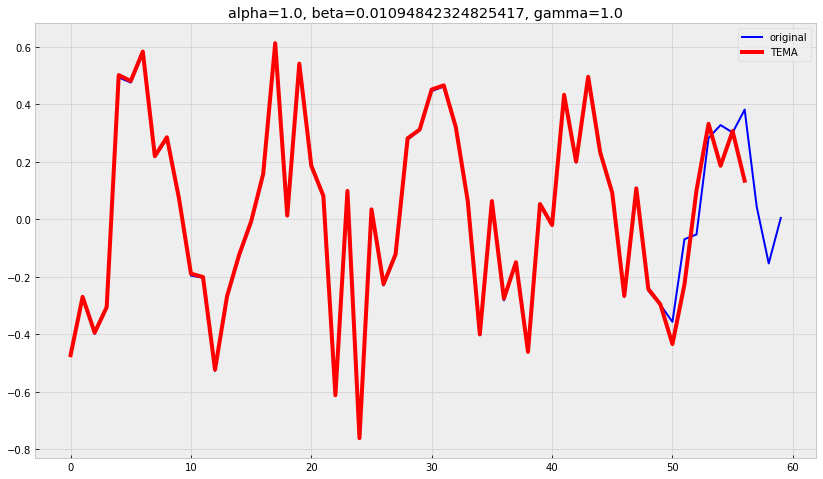

In [27]:
plot_tema(alpha_opts, beta_opts, gamma_opts, ser=trains, ser_to_plot=sales[:60], n_preds=len(val))

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = sales
y = X.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [34]:
weights = np.arange(1, len(X_train)+1)
X_train_ema = np.convolve(X_train, weights[::-1], mode='same') / weights.sum()

weights = np.arange(1, len(X_test)+1)
X_test_ema = np.convolve(X_test, weights[::-1], mode='same') / weights.sum()

In [35]:
#вычислим метрики MAE, MSE, RMSE и R2 для обучающей и тестовой выборок
mae_train = mean_absolute_error(y_train, X_train_ema)
mse_train = mean_squared_error(y_train, X_train_ema)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, X_train_ema)

mae_test = mean_absolute_error(y_test, X_test_ema)
mse_test = mean_squared_error(y_test, X_test_ema)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, X_test_ema)

print('MAE (train):', mae_train)
print('MSE (train):', mse_train)
print('RMSE (train):', rmse_train)
print('R2 (train):', r2_train)
print('MAE (test):', mae_test)
print('MSE (test):', mse_test)
print('RMSE (test):', rmse_test)
print('R2 (test):', r2_test)


MAE (train): 0.26629688987549205
MSE (train): 0.10435065652612276
RMSE (train): 0.32303352229470356
R2 (train): 0.04041999611457081
MAE (test): 0.2698061473383099
MSE (test): 0.1006469374235687
RMSE (test): 0.31724901485043056
R2 (test): -0.010692421009167452
